In [1]:
from MSCOCO import MSCOCO
import re
import random
import json

In [2]:
coco_object_categories = []
coco_classes = {}
target_classes = ['__bgr__', 'person', 'car']


with open('./mscoco_labels.txt', 'r') as f:
    for id, category in enumerate(f.readlines()):
        category = re.sub('[\d]+\W+','', category.rstrip())         
        coco_object_categories.append(category)
        coco_classes[category] = id

In [3]:
root_path = '../../../Datasets/MS COCO'
json_annotations = './json files/train_annotation.json'

In [4]:
%%time
coco_interface = MSCOCO(root_path, coco_classes, target_classes, stage='val', annotation_json_path=json_annotations)
#coco_interface = MSCOCO(root_path, coco_classes, target_classes, stage='train')

Wall time: 984 ms


['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


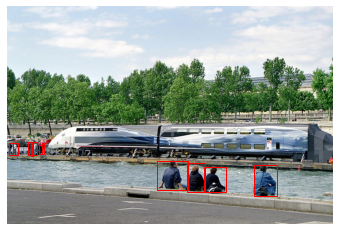

In [10]:
randindx = random.randint(0, len(coco_interface))
coco_interface.display_img(randindx)